In [1]:
import sys
import os
sys.path.append(os.getcwd() + "/..")
from ws.scraper import Scraper
from selenium import webdriver
from ws.constants import *
import json
import pandas as pd
import numpy as np

In [2]:
LEAGUES

{'Brasileirao': {'countryid': 31, 'leagueid': 95},
 'Bundesliga': {'countryid': 81, 'leagueid': 3},
 'Chinese Super League': {'countryid': 45, 'leagueid': 162},
 'Eredivisie': {'countryid': 155, 'leagueid': 13},
 'FIFA World Cup': {'countryid': 247, 'leagueid': 36},
 'La Liga': {'countryid': 206, 'leagueid': 4},
 'Liga NOS': {'countryid': 177, 'leagueid': 21},
 'Ligue 1': {'countryid': 74, 'leagueid': 22},
 'Major League Soccer': {'countryid': 233, 'leagueid': 85},
 'Premier League': {'countryid': 252, 'leagueid': 2},
 'Primera Argentina': {'countryid': 11, 'leagueid': 68},
 'Russian Premier League': {'countryid': 182, 'leagueid': 77},
 'Serie A': {'countryid': 108, 'leagueid': 5},
 'Super Lig': {'countryid': 225, 'leagueid': 17},
 'UEFA Champions League': {'countryid': 250, 'leagueid': 12},
 'UEFA Europa League': {'countryid': 250, 'leagueid': 30}}

In [7]:
from ws.loader import League, Match, MatchLoader

league = League("Serie A")
league.seasons


['2009-2010',
 '2010-2011',
 '2011-2012',
 '2012-2013',
 '2013-2014',
 '2014-2015',
 '2015-2016',
 '2016-2017',
 '2017-2018',
 '2018-2019']

In [12]:
for l in ["Serie A", "La Liga", "Premier League", "Ligue 1", "Bundesliga"]:
    
    league = League(l)
    
    for season in league.seasons:

        league.setSeason(season)
        lista = league.matcheslists[season]

        for i,matchid in enumerate(lista):

            m = league.importMatch(matchid)

            load = MatchLoader(DB,m)

            load.teams().players().matches().events()

            if (i+1) % 20 == 0:
                print(i+1,"matches done")

        print(league.league,season,"done") 






20 matches done
40 matches done
60 matches done
80 matches done
100 matches done
120 matches done
140 matches done
160 matches done
180 matches done
200 matches done
220 matches done
240 matches done
260 matches done
280 matches done
300 matches done
320 matches done
340 matches done
360 matches done
380 matches done
Serie A 2009-2010 done
20 matches done
40 matches done
60 matches done
80 matches done
100 matches done
120 matches done
140 matches done
160 matches done
180 matches done
200 matches done
220 matches done
240 matches done
260 matches done
280 matches done
300 matches done
320 matches done
340 matches done
360 matches done
380 matches done
Serie A 2010-2011 done
20 matches done
40 matches done
60 matches done
80 matches done
100 matches done
120 matches done
140 matches done
160 matches done
180 matches done
200 matches done
220 matches done
240 matches done
260 matches done
280 matches done
300 matches done
320 matches done
340 matches done
360 matches done
380 matches do

300 matches done
320 matches done
340 matches done
360 matches done
380 matches done
Premier League 2014-2015 done
20 matches done
40 matches done
60 matches done
80 matches done
100 matches done
120 matches done
140 matches done
160 matches done
180 matches done
200 matches done
220 matches done
240 matches done
260 matches done
280 matches done
300 matches done
320 matches done
340 matches done
360 matches done
380 matches done
Premier League 2015-2016 done
20 matches done
40 matches done
60 matches done
80 matches done
100 matches done
120 matches done
140 matches done
160 matches done
180 matches done
200 matches done
220 matches done
240 matches done
260 matches done
280 matches done
300 matches done
320 matches done
340 matches done
360 matches done
380 matches done
Premier League 2016-2017 done
20 matches done
40 matches done
60 matches done
80 matches done
100 matches done
120 matches done
140 matches done
160 matches done
180 matches done
200 matches done
220 matches done
240 

In [20]:
if i+1 % 20 == 0:
    print(i+1,"matches done")
        

205 matches done


In [24]:
40 % 20

0

In [11]:
for v in DB.collection_names():
    
    DB[v].delete_many({})

In [3]:
DB.collection_names()

['matches', 'teams', 'events', 'players']

In [4]:
for v in DB.collection_names():
    
    print (v,DB[v].count())

matches 16588
teams 171
events 25643315
players 9723


In [55]:
import pymongo

#DB["events"].create_index([("wsMatchId",pymongo.ASCENDING)])
#DB["events"].create_index([("teamId",pymongo.ASCENDING)])
DB["events"].create_index([("playerId",pymongo.ASCENDING)])

'playerId_1'

In [60]:
DB["events"].index_information()

{'_id_': {'key': [('_id', 1)], 'ns': 'football.events', 'v': 2},
 'playerId_1': {'key': [('playerId', 1)], 'ns': 'football.events', 'v': 2},
 'teamId_1': {'key': [('teamId', 1)], 'ns': 'football.events', 'v': 2},
 'wsMatchId_1': {'key': [('wsMatchId', 1)], 'ns': 'football.events', 'v': 2}}

In [5]:
DB["events"].find({"isShot":True}).count()

427539

In [8]:
load = MatchLoader(DB,m)

In [9]:
load.teams().players().matches().events()

In [9]:
DB["events"].count()

3293591

In [19]:
m.match.keys()

dict_keys(['playerIdNameDictionary', 'periodMinuteLimits', 'timeStamp', 'attendance', 'venueName', 'weatherCode', 'elapsed', 'startTime', 'startDate', 'score', 'htScore', 'ftScore', 'etScore', 'pkScore', 'statusCode', 'periodCode', 'home', 'away', 'maxMinute', 'minuteExpanded', 'maxPeriod', 'expandedMinutes', 'expandedMaxMinute', 'periodEndMinutes', 'commonEvents', 'events', 'timeoutInSeconds'])

In [10]:
ids = [i["wsMatchId"] for i in DB["matches"].find({"league":"La Liga"})]

In [15]:
c = list(DB["events"].find({"wsMatchId":ids[5]}))

In [24]:
lista = pd.unique([i.get("playerId",None) for i in c])

In [36]:
pd.DataFrame(list(DB["players"].find({"playerId":{"$in":list(lista)}})))

,_id,playerId,playerName
0,5b98274e95f71f229f18633b,11118,Abdoulay Konko
1,5b98282095f71f229f19542b,31388,Diego Perotti
2,5b9828a695f71f229f19eaf6,33724,Éver Banega
3,5b98293d95f71f229f1a8986,5881,Jeremy Mathieu
4,5b98293d95f71f229f1a8988,6687,Miguel Brito
5,5b98293d95f71f229f1a898c,35202,Ángel Dealbert
6,5b98293d95f71f229f1a898e,106868,Míchel
7,5b98293d95f71f229f1a8990,14102,David Silva
8,5b98293d95f71f229f1a8992,23957,Bruno
9,5b98293d95f71f229f1a8994,25363,Juan Mata


In [94]:
DB["players"].find_one({"playerName":"Lionel Messi"})

{'_id': ObjectId('5b98293f95f71f229f1a8c85'),
 'playerId': 11119,
 'playerName': 'Lionel Messi'}

In [122]:
modric = list(DB["events"].find({"playerId":25657}))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,"{'type': {'value': 59, 'displayName': 'JerseyN...","{'type': {'value': 145, 'displayName': 'Format...","{'type': {'value': 44, 'displayName': 'PlayerP...","{'type': {'value': 55, 'displayName': 'Related...",None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,"{'type': {'value': 56, 'displayName': 'Zone'},...","{'type': {'value': 140, 'displayName': 'PassEn...","{'type': {'value': 213, 'displayName': 'Angle'...","{'type': {'value': 212, 'displayName': 'Length...","{'type': {'value': 141, 'displayName': 'PassEn...",None,None,None,None,None,None,None,None,None
3,"{'type': {'value': 140, 'displayName': 'PassEn...","{'type': {'value': 56, 'displayName': 'Zone'},...","{'type': {'value': 213, 'displayName': 'Angle'...","{'type': {'value': 212, 'displayName': 'Length...","{'type': {'value': 1, 'displayName': 'Longball'}}","{'type': {'value': 141, 'displayName': 'PassEn...",None,None,None,None,None,None,None,None
4,"{'type': {'value': 285, 'displayName': 'Defens...","{'type': {'value': 56, 'displayName': 'Zone'},...","{'type': {'value': 233, 'displayName': 'Opposi...",None,None,None,None,None,None,None,None,None,None,None
5,"{'type': {'value': 145, 'displayName': 'Format...","{'type': {'value': 59, 'displayName': 'JerseyN...","{'type': {'value': 44, 'displayName': 'PlayerP...","{'type': {'value': 55, 'displayName': 'Related...",None,None,None,None,None,None,None,None,None,None
6,"{'type': {'value': 233, 'displayName': 'Opposi...","{'type': {'value': 285, 'displayName': 'Defens...","{'type': {'value': 56, 'displayName': 'Zone'},...","{'type': {'value': 13, 'displayName': 'Foul'}}",None,None,None,None,None,None,None,None,None,None
7,"{'type': {'value': 13, 'displayName': 'Foul'},...","{'type': {'value': 31, 'displayName': 'Yellow'}}",None,None,None,None,None,None,None,None,None,None,None,None
8,"{'type': {'value': 212, 'displayName': 'Length...","{'type': {'value': 56, 'displayName': 'Zone'},...","{'type': {'value': 140, 'displayName': 'PassEn...","{'type': {'value': 141, 'displayName': 'PassEn...","{'type': {'value': 213, 'displayName': 'Angle'...",None,None,None,None,None,None,None,None,None
9,"{'type': {'value': 140, 'displayName': 'PassEn...","{'type': {'value': 213, 'displayName': 'Angle'...","{'type': {'value': 141, 'displayName': 'PassEn...","{'type': {'value': 212, 'displayName': 'Length...","{'type': {'value': 56, 'displayName': 'Zone'},...",None,None,None,None,None,None,None,None,None


In [88]:
lista = pd.DataFrame(list(DB["matches"].find({"$and":[{"league":"La Liga"},{"season":"2016-2017"}]})))["wsMatchId"].values.tolist()

In [96]:
aaa = list(DB["events"].find({"$and":[{"wsMatchId":{"$in":lista}},{"playerId":11119}]}))

In [98]:
len(aaa)

2583

In [184]:
df = pd.DataFrame(modric)

In [185]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
def createPitch():
    
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color="black")
    plt.plot([0,130],[90,90], color="black")
    plt.plot([130,130],[90,0], color="black")
    plt.plot([130,0],[0,0], color="black")
    plt.plot([65,65],[0,90], color="black")
    
    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color="black")
    plt.plot([0,16.5],[65,65],color="black")
    plt.plot([16.5,0],[25,25],color="black")
    
    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color="black")
    plt.plot([113.5,113.5],[65,25],color="black")
    plt.plot([113.5,130],[25,25],color="black")
    
    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color="black")
    plt.plot([5.5,5.5],[54,36],color="black")
    plt.plot([5.5,0.5],[36,36],color="black")
    
    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color="black")
    plt.plot([124.5,124.5],[54,36],color="black")
    plt.plot([124.5,130],[36,36],color="black")
    
    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color="black",fill=False)
    #centreSpot = plt.Circle((65,45),0.8,color="black")
    #leftPenSpot = plt.Circle((11,45),0.8,color="black")
    #rightPenSpot = plt.Circle((119,45),0.8,color="black")
    
    #Draw Circles
    ax.add_patch(centreCircle)
    #ax.add_patch(centreSpot)
    #ax.add_patch(leftPenSpot)
    #ax.add_patch(rightPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Tidy Axes
    plt.axis('off')
    
    
    #Display Pitch
    #plt.show()
    return ax


In [162]:
df = df[df["wsMatchId"] == 969899]

In [172]:
df[["x","y","isGoal"]].fillna(0)["isGoal"]

0       4566
True       5
Name: isGoal, dtype: int64

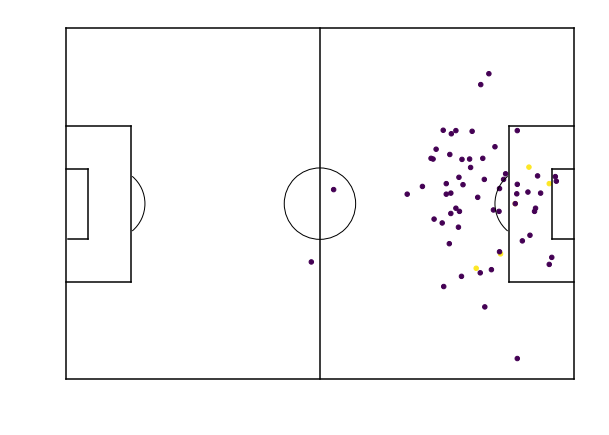

In [186]:
%matplotlib inline
ax = createPitch()
df["x"] = df["x"]*1.3
df["y"] = df["y"]*0.9
df[["x","y","isGoal","isShot"]][df["isShot"] == True].fillna(False).plot.scatter(x="x",y="y",c="isGoal",ax=ax,figsize=(10,20),colorbar=False,colormap="viridis")
ax.set_aspect("equal")
plt.show()


In [154]:
df["wsMatchId"]

0      969899
1      969899
2      969899
3      969899
4      969910
5      969910
6      969910
7      969918
8      969918
9      969918
10     969918
11     969967
12    1090795
13    1090801
14    1090852
15    1090852
16    1090862
17    1090870
18    1090898
19    1090909
20    1090909
21    1090912
22    1090957
23    1090958
24    1090958
25    1091011
26    1091011
27    1091017
28    1091038
29    1091120
       ...   
35    1201865
36    1201865
37    1201932
38    1201932
39    1201941
40    1201941
41    1201941
42    1202010
43    1202028
44    1202028
45    1202028
46    1202028
47    1202035
48    1202054
49    1202054
50    1202060
51    1202060
52    1202063
53    1202063
54    1202063
55    1202068
56    1202068
57    1202086
58    1202106
59    1202112
60    1202112
61    1202115
62    1202133
63    1202133
64    1294556
Name: wsMatchId, Length: 65, dtype: int64

In [125]:
def calculateMinutes(c):
    
    maxMinute = np.max([i["expandedMinute"] for i in c])

    starters = []
    subs = {}
    for i in c:

        try:
            if (i["type"]["displayName"] == "FormationSet"):

                for q in i["qualifiers"]:
                    if q["type"]["displayName"] == "InvolvedPlayers":

                        starters.extend(list(map(int,q["value"].split(",")))[0:11])
            elif (i["type"]["displayName"] == "SubstitutionOn"):
                 subs[i["playerId"]] = maxMinute - i["expandedMinute"]
                 subs[i["relatedPlayerId"]] = i["expandedMinute"]

            else:
                continue
        except:
            print("error")
            continue


    players = {k:maxMinute for k in starters}
    players.update(subs)


    return players

In [76]:
calculateMinutes(list(DB["events"].find({"wsMatchId":969826})))

{47: 95,
 879: 33,
 2339: 62,
 2352: 95,
 2494: 95,
 2602: 95,
 3929: 95,
 4203: 75,
 4387: 95,
 5881: 48,
 6319: 95,
 6687: 95,
 6967: 70,
 7829: 20,
 8943: 25,
 9255: 95,
 9418: 95,
 9446: 95,
 11118: 95,
 14102: 86,
 23757: 39,
 23957: 47,
 25363: 95,
 29571: 95,
 31388: 56,
 33724: 95,
 35202: 95,
 106868: 9}

In [170]:
c = list(DB["matches"].find())

In [177]:
pd.DataFrame(c)

ValueError: DataFrame constructor not properly called!

In [111]:
mins = [i["expandedMinute"] for i in c]

In [114]:
np.max(mins)

96

In [128]:
c[3]

{'_id': ObjectId('5b98293c2607a5029bb4f829'),
 'endX': 37.7,
 'endY': 48.3,
 'eventId': 4,
 'expandedMinute': 0,
 'id': 1623193658.0,
 'isTouch': True,
 'minute': 0,
 'outcomeType': {'displayName': 'Successful', 'value': 1},
 'period': {'displayName': 'FirstHalf', 'value': 1},
 'playerId': 1106,
 'qualifiers': [{'type': {'displayName': 'Zone', 'value': 56},
   'value': 'Back'},
  {'type': {'displayName': 'PassEndX', 'value': 140}, 'value': '37.7'},
  {'type': {'displayName': 'PassEndY', 'value': 141}, 'value': '48.3'}],
 'satisfiedEventsTypes': [90, 116, 29, 34, 36, 215, 216],
 'second': 5,
 'teamId': 52,
 'type': {'displayName': 'Pass', 'value': 1},
 'wsEventId': '3349671623193658.0',
 'wsMatchId': 334967,
 'x': 53.0,
 'y': 46.6}

In [153]:
maxMinute = np.max([i["expandedMinute"] for i in c])

starters = []
subs = {}
for i in c:
    
    try:
        if (i["type"]["displayName"] == "FormationSet"):
            
            for q in i["qualifiers"]:
                if q["type"]["displayName"] == "InvolvedPlayers":
                    
                    starters.extend(list(map(int,q["value"].split(",")))[0:11])
        elif (i["type"]["displayName"] == "SubstitutionOn"):
             subs[i["playerId"]] = maxMinute - i["expandedMinute"]
             subs[i["relatedPlayerId"]] = i["expandedMinute"]
                
        else:
            continue
    except:
        print("error")
        continue


players = {k:maxMinute for k in starters}
players.update(subs)


return players
        
    
        

In [157]:
pd.Series(players,name="minutesPlayed")

1063     12
1106     64
1141     70
1688     26
2187     22
2776     96
3172     96
3577     84
4961     96
5583     96
9257     96
9283     96
10051    74
11104    96
12575    96
14079    96
14100    31
14258    96
14296    74
17106    96
18285    96
19729    22
20241    96
21019    96
22152    96
23693    65
23758    32
34045    96
Name: minutesPlayed, dtype: int64

In [147]:
starters.update(subs)

In [149]:
len(starters.keys())

28

In [105]:
players

'2776,11104,20241,4961,12575,14079,5583,18285,14296,3577,1106,17651,1063,23170,19729,2288,23758,3403'

In [116]:
subs

[{'_id': ObjectId('5b98293c2607a5029bb4fbbc'),
  'eventId': 551,
  'expandedMinute': 64,
  'id': 272165828.0,
  'isTouch': False,
  'minute': 62,
  'outcomeType': {'displayName': 'Successful', 'value': 1},
  'period': {'displayName': 'SecondHalf', 'value': 2},
  'playerId': 23758,
  'qualifiers': [{'type': {'displayName': 'RelatedEventId', 'value': 55},
    'value': '550'},
   {'type': {'displayName': 'FormationSlot', 'value': 145}, 'value': '11'},
   {'type': {'displayName': 'JerseyNumber', 'value': 59}, 'value': '24'},
   {'type': {'displayName': 'PlayerPosition', 'value': 44},
    'value': 'Midfielder'}],
  'relatedEventId': 550,
  'relatedPlayerId': 1106,
  'satisfiedEventsTypes': [212],
  'second': 10,
  'teamId': 52,
  'type': {'displayName': 'SubstitutionOn', 'value': 19},
  'wsEventId': '334967272165828.0',
  'wsMatchId': 334967,
  'x': 0.0,
  'y': 0.0},
 {'_id': ObjectId('5b98293c2607a5029bb4fbd3'),
  'eventId': 469,
  'expandedMinute': 65,
  'id': 695742947.0,
  'isTouch': Fa

In [119]:
a = list(map(int,players.split(",")))[0:11]

In [118]:
aaa = []

In [120]:
aaa.extend(a)

In [121]:
aaa

[2776, 11104, 20241, 4961, 12575, 14079, 5583, 18285, 14296, 3577, 1106]

In [69]:
aaa = sorted(DB["events"].distinct("type.displayName"))

In [71]:
lista = []

for i in c:
    
    d = {}
    
    

[{'_id': ObjectId('5b98293c2607a5029bb4f826'),
  'eventId': 2,
  'expandedMinute': 0,
  'id': 1163992171.0,
  'isTouch': False,
  'minute': 0,
  'outcomeType': {'displayName': 'Successful', 'value': 1},
  'period': {'displayName': 'FirstHalf', 'value': 1},
  'qualifiers': [],
  'satisfiedEventsTypes': [],
  'second': 0,
  'teamId': 59,
  'type': {'displayName': 'Start', 'value': 32},
  'wsEventId': '3349671163992171.0',
  'wsMatchId': 334967,
  'x': 0.0,
  'y': 0.0},
 {'_id': ObjectId('5b98293c2607a5029bb4f827'),
  'eventId': 2,
  'expandedMinute': 0,
  'id': 1996244779.0,
  'isTouch': False,
  'minute': 0,
  'outcomeType': {'displayName': 'Successful', 'value': 1},
  'period': {'displayName': 'FirstHalf', 'value': 1},
  'qualifiers': [],
  'satisfiedEventsTypes': [],
  'second': 0,
  'teamId': 52,
  'type': {'displayName': 'Start', 'value': 32},
  'wsEventId': '3349671996244779.0',
  'wsMatchId': 334967,
  'x': 0.0,
  'y': 0.0},
 {'_id': ObjectId('5b98293c2607a5029bb4f828'),
  'endX':

In [70]:
aaa

['Aerial',
 'BallRecovery',
 'BallTouch',
 'BlockedPass',
 'Card',
 'Challenge',
 'ChanceMissed',
 'Claim',
 'Clearance',
 'CornerAwarded',
 'CrossNotClaimed',
 'Dispossessed',
 'End',
 'Error',
 'FormationChange',
 'FormationSet',
 'Foul',
 'Goal',
 'GoodSkill',
 'Interception',
 'KeeperPickup',
 'KeeperSweeper',
 'MissedShots',
 'OffsideGiven',
 'OffsidePass',
 'OffsideProvoked',
 'Pass',
 'PenaltyFaced',
 'Punch',
 'Save',
 'SavedShot',
 'ShieldBallOpp',
 'ShotOnPost',
 'Smother',
 'Start',
 'SubstitutionOff',
 'SubstitutionOn',
 'Tackle',
 'TakeOn',
 'Turnover']

In [34]:

    
lista = [{"id":i["_id"],
        "minute":i["expandedMinute"]} for i in DB["events"].find({"wsMatchId":{"$in":ids}})]
    

In [ ]:
DB["matches"].find({"wsMatchId":c[0]["wsMatchId"]})[0]

In [3]:
DB["events"].find({"type.displayName":"Pass"})[1]["qualifiers"]

[{'type': {'displayName': 'PassEndY', 'value': 141}, 'value': '49.2'},
 {'type': {'displayName': 'Angle', 'value': 213}, 'value': '3.2'},
 {'type': {'displayName': 'Zone', 'value': 56}, 'value': 'Back'},
 {'type': {'displayName': 'PassEndX', 'value': 140}, 'value': '29.8'},
 {'type': {'displayName': 'Length', 'value': 212}, 'value': '22.5'}]

In [34]:
pd.to_datetime(DB["matches"].find_one()["date"])

Timestamp('2018-08-12 15:00:00')

In [5]:
class Match():
    
    def __init__(self,matchid,league,season,jsonpath=JSONPATH):
        
        self.league = league
        self.season = season
        self.leaguename = self.league.lower().replace(" ","_")
        self.matchid = matchid
        self.jsonpath = jsonpath
        self.matchpath = jsonpath+self.leaguename+"/"+self.season+"/"+str(self.matchid)+".json"
        self.match = json.load(open(self.matchpath,"r",encoding="utf-8"),encoding="utf-8")
        
        self.__matchInfo__()
        self.__events__()
        self.__players__()
        self.__teams__()
        
    def __matchInfo__(self):
        
        matches_dict = {}
        
        try:
            matches_dict["wsmatchid"] = self.matchid
        except KeyError:
            matches_dict["wsmatchid"] = np.nan
        try:
            matches_dict["league"] = self.league
        except KeyError:
            matches_dict["league"] = np.nan
        try:
            matches_dict["season"] = self.season
        except KeyError:
            matches_dict["season"] = np.nan
        try:
            matches_dict["date"] = pd.to_datetime(self.match["startTime"].replace("T"," "))
        except KeyError:
            matches_dict["date"] = np.nan
        try:
            matches_dict["hometeamid"] = self.match["home"]["teamId"]
        except KeyError:
            matches_dict["hometeamid"] = np.nan
        try:
            matches_dict["awayteamid"] = self.match["away"]["teamId"]
        except KeyError:
            matches_dict["awayteamid"] = np.nan
        try:
            matches_dict["hometeamname"] = self.match["home"]["name"]
        except KeyError:
            matches_dict["hometeamname"] = np.nan
        try:
            matches_dict["awayteamname"] = self.match["away"]["name"]
        except KeyError:
            matches_dict["awayteamname"] = np.nan
        try:
            matches_dict["homescore"] = self.match["score"].split(" : ")[0]
        except KeyError:
            matches_dict["homescore"] = np.nan
        try:
            matches_dict["awayscore"] = self.match["score"].split(" : ")[1]
        except KeyError:
            matches_dict["awayscore"] = np.nan
        try:
            if self.match["pkScore"] == '':
                matches_dict["homepkscore"] = np.nan
                matches_dict["awaypkscore"] = np.nan
            else:
                matches_dict["homepkscore"] = self.match["pkScore"].split(" : ")[0]
                matches_dict["awaypkscore"] = self.match["pkScore"].split(" : ")[1]
        except KeyError:
            matches_dict["homepkscore"] = np.nan
            matches_dict["awaypkscore"] = np.nan
        try:
            matches_dict["referee"] = self.match["referee"]["name"]
        except KeyError:
            matches_dict["referee"] = np.nan
        try:
            matches_dict["managerhome"] = self.match["home"]["managerName"]
        except KeyError:
            matches_dict["managerhome"] = np.nan
        try:
            matches_dict["manageraway"] = self.match["away"]["managerName"]
        except KeyError:
            matches_dict["manageraway"] = np.nan
        try:
            matches_dict["attendance"] = self.match["attendance"]
        except KeyError:
            matches_dict["attendance"] = np.nan
        try:
            matches_dict["venuename"] = self.match["venueName"]
        except KeyError:
            matches_dict["venuename"] = np.nan
        
        column_order = ["wsmatchid","league","season","date","hometeamid",
                        "awayteamid","hometeamname","awayteamname","homescore",
                        "awayscore","homepkscore","awaypkscore","referee",
                        "managerhome","manageraway","attendance","venuename"]
        
        self.matchinfo = pd.Series(matches_dict)[column_order]
        
        #return self.matchinfo
    
    def __events__(self):
            
        events = self.match["events"]
        event_list=[]
        qual_list=[]

        for event in events:
            events_dict = {}
            try:
                events_dict["keyid"] = str(self.matchid)+str(event["id"])
            except KeyError:
                events_dict["keyid"] = np.nan
            try:
                events_dict["wsmatchid"] = self.matchid
            except KeyError:
                events_dict["wsmatchid"] = np.nan
            try:
                events_dict["wseventid"] = str(event["id"])
            except KeyError:
                events_dict["wseventid"] = np.nan
            try:
                events_dict["matcheventid"] = event["eventId"]
            except KeyError:
                events_dict["matcheventid"] = np.nan
            try:
                events_dict["minute"] = event["minute"]
            except KeyError:
                events_dict["minute"] = np.nan
            try:
                events_dict["second"] = event["second"]
            except KeyError:
                events_dict["second"] = np.nan
            try:
                events_dict["expandedminute"] = event["expandedMinute"]
            except KeyError:
                events_dict["expandedminute"] = np.nan
            try:
                events_dict["teamid"] = event["teamId"]
            except KeyError:
                events_dict["teamid"] = np.nan
            try:
                events_dict["playerid"] = event["playerId"]
            except KeyError:
                events_dict["playerid"] = np.nan
            try:
                events_dict["period"] = event["period"]["displayName"]
            except KeyError:
                events_dict["period"] = np.nan
            try:
                events_dict["typeid"] = event["type"]["value"]
            except KeyError:
                events_dict["typeid"] = np.nan
            try:
                events_dict["type"] = event["type"]["displayName"]
            except KeyError:
                events_dict["type"] = np.nan
            try:
                events_dict["outcometype"] = event["outcomeType"]["displayName"]
            except KeyError:
                events_dict["outcometype"] = np.nan
            try:
                events_dict["x"] = event["x"]
            except KeyError:
                events_dict["x"] = np.nan
            try:
                events_dict["y"] = event["y"]
            except KeyError:
                events_dict["y"] = np.nan

            event_list.append(events_dict)

            qualifiers = event["qualifiers"]
            
            for qualifier in qualifiers:
                    qual_dict = {}
                    try:
                        qual_dict["keyid"] = events_dict["keyid"]
                    except KeyError:
                        qual_dict["keyid"] = np.nan
                    try:
                        qual_dict["wsmatchid"] = self.matchid
                    except KeyError:
                        qual_dict["wsmatchid"] = np.nan
                    try:
                        qual_dict["wseventid"] = events_dict["wseventid"]
                    except KeyError:
                        qual_dict["wseventid"] = np.nan
                    try:
                        qual_dict["matcheventid"] = events_dict["matcheventid"]
                    except KeyError:
                        qual_dict["matcheventid"] = np.nan
                    try:
                        qual_dict["qualid"] = qualifier["type"]["value"]
                    except KeyError:
                        qual_dict["qualid"] = np.nan
                    try:
                        qual_dict["qualname"] = qualifier["type"]["displayName"]
                    except KeyError:
                        qual_dict["qualname"] = np.nan
                    try:
                        try:
                            value = float(qualifier["value"])
                        except ValueError:
                            value = qualifier["value"]
                        if type(value) == str:
                            qual_dict["qualvaluetext"] = value
                            qual_dict["qualvalue"] = np.nan
                        else:
                            qual_dict["qualvaluetext"] = np.nan
                            qual_dict["qualvalue"] = value    
                    except KeyError:
                        qual_dict["qualvalue"] = 1
                        qual_dict["qualvaluetext"] = np.nan
                    qual_list.append(qual_dict)
    
        self.events = pd.DataFrame(event_list)[["keyid","wsmatchid","wseventid","matcheventid","minute","second","expandedminute","teamid",
                                   "playerid","period","typeid","type","outcometype","x","y"]].set_index("keyid")
        
        self.qualifiers = pd.DataFrame(qual_list)[["keyid","wsmatchid","wseventid","matcheventid","qualid","qualname","qualvalue","qualvaluetext"]].set_index("keyid")
        
        #return self.events, self.qualifiers
        
        
        
    def __players__(self):
        
        dic = [{"playerid":k,"playername":v} for k,v in self.match["playerIdNameDictionary"].items()]
        self.players = pd.DataFrame(dic,index=range(len(dic))).set_index("playerid")
        
        #return self.players
        
    def __teams__(self):
        
        d = {"home":{"teamid":self.matchinfo["hometeamid"],
                "teamname":self.matchinfo["hometeamname"]},
         
        "away":{"teamid":self.matchinfo["awayteamid"],
                "teamname":self.matchinfo["awayteamname"]}}
        
        self.teams = pd.DataFrame(d).T
        
        #return self.teams
        

In [7]:
m = le.importMatch(le.matcheslists["2017-2018"][12])

In [15]:
pd.unique(m.events["period"])

array(['FirstHalf', 'SecondHalf', 'PostGame', 'PreMatch'], dtype=object)

In [8]:
m.match["events"][3]

{'endX': 38.9,
 'endY': 49.9,
 'eventId': 4,
 'expandedMinute': 0,
 'id': 1807661006.0,
 'isTouch': True,
 'minute': 0,
 'outcomeType': {'displayName': 'Successful', 'value': 1},
 'period': {'displayName': 'FirstHalf', 'value': 1},
 'playerId': 14546,
 'qualifiers': [{'type': {'displayName': 'PassEndX', 'value': 140},
   'value': '38.9'},
  {'type': {'displayName': 'Zone', 'value': 56}, 'value': 'Back'},
  {'type': {'displayName': 'Angle', 'value': 213}, 'value': '3.1'},
  {'type': {'displayName': 'PassEndY', 'value': 141}, 'value': '49.9'},
  {'type': {'displayName': 'Length', 'value': 212}, 'value': '11.0'}],
 'satisfiedEventsTypes': [90, 116, 29, 34, 36, 215, 217],
 'second': 2,
 'teamId': 903,
 'type': {'displayName': 'Pass', 'value': 1},
 'x': 49.4,
 'y': 49.1}

In [10]:
import datetime

In [11]:
m.events

,wsmatchid,wseventid,matcheventid,minute,second,expandedminute,teamid,playerid,period,typeid,type,outcometype,x,y
keyid,,,,,,,,,,,,,,
12314211588429394.0,1231421,1588429394.0,2.0,0,0.0,0,6147,NaN,FirstHalf,32,Start,Successful,0.0,0.0
12314211437274719.0,1231421,1437274719.0,2.0,0,0.0,0,896,NaN,FirstHalf,32,Start,Successful,0.0,0.0
12314212061939547.0,1231421,2061939547.0,5.0,0,1.0,0,6147,91574.0,FirstHalf,1,Pass,Successful,49.9,50.7
12314211146880972.0,1231421,1146880972.0,6.0,0,2.0,0,6147,303656.0,FirstHalf,1,Pass,Successful,33.5,49.7
12314211581883914.0,1231421,1581883914.0,7.0,0,5.0,0,6147,125444.0,FirstHalf,1,Pass,Successful,27.1,24.8
12314211346966372.0,1231421,1346966372.0,8.0,0,8.0,0,6147,126079.0,FirstHalf,1,Pass,Successful,40.5,18.0
12314211322744539.0,1231421,1322744539.0,9.0,0,10.0,0,6147,126186.0,FirstHalf,1,Pass,Successful,33.5,6.0
12314211617717134.0,1231421,1617717134.0,10.0,0,12.0,0,6147,125498.0,FirstHalf,1,Pass,Unsuccessful,39.7,22.3
12314211318024005.0,1231421,1318024005.0,846.0,0,13.0,0,896,68939.0,FirstHalf,61,BallTouch,Unsuccessful,34.9,76.9


In [33]:
datetime.timedelta(minutes=1,seconds=60).total_seconds()

120.0

In [16]:
m.events.apply(lambda x: datetime.timedelta(seconds=x.second))

AttributeError: ("'Series' object has no attribute 'second'", 'occurred at index wsmatchid')

In [26]:
np.unique([i["type"]["displayName"] for i in m.match["events"]])

array(['Aerial', 'BallRecovery', 'BallTouch', 'BlockedPass', 'Card',
       'Challenge', 'Clearance', 'CornerAwarded', 'Dispossessed', 'End',
       'Error', 'FormationChange', 'FormationSet', 'Foul', 'Goal',
       'Interception', 'KeeperPickup', 'MissedShots', 'OffsideGiven',
       'OffsidePass', 'OffsideProvoked', 'Pass', 'PenaltyFaced', 'Punch',
       'Save', 'SavedShot', 'ShotOnPost', 'Start', 'SubstitutionOff',
       'SubstitutionOn', 'Tackle', 'TakeOn'],
      dtype='<U15')

In [6]:
from pymongo import MongoClient

In [7]:
c = MongoClient()

In [13]:
c.drop_database("football")

In [8]:
c.database_names()

['admin', 'local']

In [13]:
db = c["football"]

In [17]:
db["teams"]

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'football'), 'teams')

In [19]:
teams = db["teams"]

In [31]:
for matchid in le.matcheslists["2017-2018"]:
    
    match = le.getMatch(matchid)
    
    team1 = {"teamId":match.match["home"]["teamId"],
            "teamName":match.match["home"]["name"],
            }
    team2 = {"teamId":match.match["away"]["teamId"],
            "teamName":match.match["away"]["name"],
            }
    
    if teams.count({"teamId":team1["teamId"]}) == 0:
        teams.insert(team1)
        print("team inserted")

/Users/cgnal/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  del sys.path[0]


team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted
team inserted


In [45]:
for matchid in le.matcheslists["2017-2018"]:
    
    match = le.getMatch(matchid).match

    teams.update_one({'teamId': match['home']['teamId']}, 
                     {'$setOnInsert': {'teamName': match['home']['name']}}, upsert=True)
    teams.update_one({'teamId': match['away']['teamId']}, 
                     {'$setOnInsert': {'teamName': match['away']['name']}}, upsert=True)
    
    for k,v in match["playerIdNameDictionary"].items():
        
         db["players"].update_one({"playerId":int(k)},
                                 {'$setOnInsert': {'playerName': v}}, upsert=True)
        
        

In [52]:
teams.find_one({"teamName":"Boca Juniors"})["teamId"]

889

In [51]:
str(db["players"].find_one()["_id"])

'5b979bdb7425c3424643aa92'

In [48]:
match.keys()

dict_keys(['playerIdNameDictionary', 'periodMinuteLimits', 'timeStamp', 'attendance', 'venueName', 'referee', 'weatherCode', 'elapsed', 'startTime', 'startDate', 'score', 'htScore', 'ftScore', 'etScore', 'pkScore', 'statusCode', 'periodCode', 'home', 'away', 'maxMinute', 'minuteExpanded', 'maxPeriod', 'expandedMinutes', 'expandedMaxMinute', 'periodEndMinutes', 'commonEvents', 'events', 'timeoutInSeconds'])

In [59]:
match["startTime"]

'2017-09-24T18:05:00'

In [61]:
match["home"].keys()

dict_keys(['teamId', 'formations', 'stats', 'incidentEvents', 'shotZones', 'name', 'countryName', 'players', 'managerName', 'scores', 'field', 'averageAge'])

In [11]:
match["events"][1]

NameError: name 'match' is not defined

In [147]:
import requests
r = requests.get('https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/7298.json')

In [149]:
f = r.json()

In [152]:
pd.DataFrame(f)

,bad_behaviour,ball_receipt,ball_recovery,block,dribble,duel,duration,foul_committed,foul_won,goalkeeper,...,possession_team,related_events,second,shot,substitution,tactics,team,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,...,"{'id': 746, 'name': 'Manchester City WFC'}",NaN,0,NaN,NaN,"{'formation': 433, 'lineup': [{'player': {'id'...","{'id': 746, 'name': 'Manchester City WFC'}",00:00:00.000,"{'id': 35, 'name': 'Starting XI'}",NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,...,"{'id': 746, 'name': 'Manchester City WFC'}",NaN,0,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...","{'id': 745, 'name': 'Chelsea LFC'}",00:00:00.000,"{'id': 35, 'name': 'Starting XI'}",NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,8.160,NaN,NaN,NaN,...,"{'id': 746, 'name': 'Manchester City WFC'}",[0c9ba151-f220-4b4b-bac1-948e9e396ab0],0,NaN,NaN,NaN,"{'id': 745, 'name': 'Chelsea LFC'}",00:00:00.000,"{'id': 18, 'name': 'Half Start'}",NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,7.960,NaN,NaN,NaN,...,"{'id': 746, 'name': 'Manchester City WFC'}",[f8bdb5ec-8476-4070-b246-6ac94c643c14],0,NaN,NaN,NaN,"{'id': 746, 'name': 'Manchester City WFC'}",00:00:00.000,"{'id': 18, 'name': 'Half Start'}",NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,...,"{'id': 745, 'name': 'Chelsea LFC'}",[75bf2abe-0d3b-416b-9a83-445e715f6ea3],0,NaN,NaN,NaN,"{'id': 745, 'name': 'Chelsea LFC'}",00:00:00.100,"{'id': 30, 'name': 'Pass'}",NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'id': 745, 'name': 'Chelsea LFC'}",[e02a9881-b244-4844-a3db-9df947ec1b09],0,NaN,NaN,NaN,"{'id': 745, 'name': 'Chelsea LFC'}",00:00:00.100,"{'id': 42, 'name': 'Ball Receipt*'}",NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,0.373,NaN,NaN,NaN,...,"{'id': 745, 'name': 'Chelsea LFC'}",[96f069fb-7ae4-443c-a4a6-182ea5f3691a],0,NaN,NaN,NaN,"{'id': 746, 'name': 'Manchester City WFC'}",00:00:00.340,"{'id': 17, 'name': 'Pressure'}",NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,1.640,NaN,NaN,NaN,...,"{'id': 745, 'name': 'Chelsea LFC'}","[0a8333e3-7b99-420e-8b18-2895be4e16e5, 2073010...",0,NaN,NaN,NaN,"{'id': 745, 'name': 'Chelsea LFC'}",00:00:00.500,"{'id': 30, 'name': 'Pass'}",True
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'id': 745, 'name': 'Chelsea LFC'}",[96f069fb-7ae4-443c-a4a6-182ea5f3691a],2,NaN,NaN,NaN,"{'id': 745, 'name': 'Chelsea LFC'}",00:00:02.140,"{'id': 42, 'name': 'Ball Receipt*'}",NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,0.733,NaN,NaN,NaN,...,"{'id': 745, 'name': 'Chelsea LFC'}",NaN,2,NaN,NaN,NaN,"{'id': 746, 'name': 'Manchester City WFC'}",00:00:02.700,"{'id': 17, 'name': 'Pressure'}",NaN
